Create and save masks for Semantic Segmentation models,
given aerial images and buildings coordinates.

In [30]:
import pandas as pd
import numpy as np
import os
from PIL import Image, ImageDraw, ImageOps
import json

define helper functions

In [6]:
#file names look like 'swissimage-dop10_2019_X_Y_4.0_2056.tif', where X and Y are left bottom corner coordinates
def get_image_coordinates(filename):
    xy = []
    xy.append(int(filename.split('_')[2]))
    xy.append(int(filename.split('_')[3]))
    return tuple(xy)

In [7]:
def get_file_names(path):
    filenames = []
    for file in os.listdir(path):
        name, extension = os.path.splitext(file)
        if extension == '.tif':
            filenames.append(file)
    return filenames

In [8]:
#create list of buildings with relative coordinates for each image, 
#xy - coordinates from file name 
#img_size_coord - size of image in swiss coordinates
#img_size - resolution in pixels
def buildings_one_img(img_x, img_y, img_size_coord, img_size):
    scale = img_size/img_size_coord
    tmp = data[(data.max_Y>=img_y) & (data.min_Y<(img_y+img_size_coord)) & (data.max_X >= img_x) & (data.min_X < (img_x+img_size_coord))]
    X_relative, Y_relative, XY_relative = [], [], []
    for x in tmp.X:
        x_tmp = []
        for i in x:
            x_tmp.append((i- img_x)*scale)
        X_relative.append(x_tmp)
    for y in tmp.Y:
        y_tmp = []
        for i in y:
            y_tmp.append(img_size - ((i - img_y)*scale))
        Y_relative.append(y_tmp)
    for i in range(len(X_relative)):
        XY_relative.append(list(zip(X_relative[i], Y_relative[i])))
    res = list(zip(tmp['art'], XY_relative))
    return res

In [9]:
#draw and save mask
#file - file name
#path_to_save_mask
#img_buildings_dict - dictionary of all buildings for each image
def save_mask(file, path_to_save_mask, img_buildings_dict, img_size):
    empty_img, input_img, target = [], [], []
    name, extension = os.path.splitext(file)
    if extension == '.tif':
        im = Image.new("L", (img_size, img_size))
        if not img_buildings_dict[file]:
            empty_img.append(file)
        else:
            input_img.append(file)
            target.append('mask_' + file)
            #im = Image.open(f + file) 
            draw = ImageDraw.Draw(im)
            for building in img_buildings_dict[file]:
                #draw.polygon(building[1], fill=colors[building[0]])
                draw.polygon([tuple(x) for x in building[1]], fill=class_colors[building[0]]) #outline=123 color
            im.save(path_to_save_mask + 'mask_' + file)

load DataFrame with all buildings and coordinates

In [2]:
data = pd.read_json('./data/buildings_projects_minmax.json')

In [3]:
data.head()

,OBJID,art,XY,X,Y,max_X,min_X,max_Y,min_Y
0,2862,Wohnen,"[[2678936.554, 1237294.736], [2678936.521, 123...","[2678936.554, 2678936.521, 2678936.487, 267893...","[1237294.736, 1237294.7010000001, 1237294.668,...",2678941.837,2678908.705,1237322.447,1237292.967
1,2859,Nebengebaeude,"[[2679333.7430000002, 1235704.501], [2679337.1...","[2679333.7430000002, 2679337.153, 2679343.293,...","[1235704.501, 1235708.382, 1235713.8460000001,...",2679346.373,2679333.743,1235713.846,1235701.348
2,2853,Wohnen,"[[2679352.15, 1235695.063], [2679352.017, 1235...","[2679352.15, 2679352.017, 2679351.884, 2679339...","[1235695.063, 1235694.913, 1235694.763, 123568...",2679352.150,2679326.308,1235703.172,1235676.180
3,2845,Wohnen,"[[2679184.73, 1235881.311], [2679184.784, 1235...","[2679184.73, 2679184.784, 2679190.44, 2679190....","[1235881.311, 1235881.4070000001, 1235891.368,...",2679198.523,2679184.730,1235891.613,1235876.798
4,2839,Wohnen,"[[2679354.201, 1235437.204], [2679348.918, 123...","[2679354.201, 2679348.918, 2679353.835, 267935...","[1235437.204, 1235439.942, 1235449.409, 123544...",2679359.121,2679348.918,1235449.409,1235437.204


create label for each class

In [4]:
labels = list(data.art.value_counts().index)
classes = list(range(1,9))
class_colors = dict()
for i, j in enumerate(labels):
    class_colors[j] = classes[i]
class_colors

{'Wohnen': 1,
 'Nebengebaeude': 2,
 'Landwirtschaft': 3,
 'Industrie': 4,
 'Verwaltung': 5,
 'Handel': 6,
 'Verkehr': 7,
 'Gastgewerbe': 8}

In [24]:
input_path = r'./data_img_sliced/_zurich_balanced_125/'
target_path = r'./data_img_sliced/_zurich_balanced_125_mask/'

get original images filenames 

In [14]:
filenames = sorted(get_file_names(input_path))

create dictionary of all buildings for each image

In [38]:
IMG_SIZE = 125

In [20]:
#key - image name
#value - all buildings in this image
size_swiss_coord = 50
buildings_img_125 = dict()
for file in list(filenames[:10]):
    xy = get_image_coordinates(file)
    buildings = buildings_one_img(xy[0], xy[1], size_swiss_coord, IMG_SIZE)
    if len(buildings):
        buildings_img_125[file] = buildings

In [21]:
buildings_img_125['swissimage-dop10_2019_2669600_1261150_4.0_2056.tif']

[('Landwirtschaft',
  [(77.70250000059605, 20.18999999971129),
   (43.04000000003725, -37.12500000023283),
   (89.77500000037253, -65.43500000028871),
   (108.59500000020489, -34.284999999799766),
   (109.40750000067055, -34.777500000200234),
   (111.19000000064261, -31.82749999978114),
   (115.37750000017695, -34.3650000001071),
   (129.37249999959022, -11.080000000074506),
   (93.57250000000931, 10.584999999846332),
   (77.70250000059605, 20.18999999971129)]),
 ('Landwirtschaft',
  [(120.00499999965541, 87.92249999998603),
   (108.82749999989755, 69.23750000016298),
   (115.65000000060536, 65.12999999977183),
   (103.72749999980442, 45.200000000186265),
   (122.77750000008382, 33.73250000004191),
   (135.97500000032596, 55.715000000200234),
   (145.89999999967404, 72.24500000011176),
   (120.00499999965541, 87.92249999998603)])]

create and save masks

In [26]:
for file in buildings_img_125.keys():
    save_mask(file, target_path, buildings_img_125, IMG_SIZE)

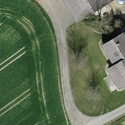

In [33]:
Image.open(input_path + 'swissimage-dop10_2019_2669600_1261150_4.0_2056.tif')

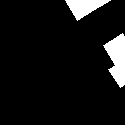

In [37]:
mask = Image.open(target_path + 'mask_swissimage-dop10_2019_2669600_1261150_4.0_2056.tif')
ImageOps.autocontrast(mask)